In [104]:
# Preprocessing
import pandas as pd
import tables
import time
import numpy as np
import gc
from tqdm import tqdm_notebook
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
from data_utils.data_generator import DataGenerator
sys.path.append('/home/iprovilkov/data/JUNO/notebooks/')

In [37]:
from data_utils.data_processing import get_data_2dprojection

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [4]:
from tensorflow.python.client import device_lib
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [5]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16209489301377702579, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11280557671
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18007889932333195317
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: e8d8:00:00.0, compute capability: 3.7"]

In [6]:
import keras
import keras.layers as L
from keras.models import Sequential
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [7]:
from keras import layers
from keras import models


#
# image dimensions
#

img_height = 150
img_width = 150
img_channels = 2

#
# network params
#

cardinality = 1


def residual_network_tail(x):
    """
    ResNeXt by default. For ResNet set `cardinality` = 1 above.
    
    """
    def add_common_layers(y):
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU()(y)

        return y

    def grouped_convolution(y, nb_channels, _strides):
        # when `cardinality` == 1 this is just a standard convolution
        if cardinality == 1:
            return layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
        
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
        # and convolutions are separately performed within each group
        groups = []
        for j in range(cardinality):
            group = layers.Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
            groups.append(layers.Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))
            
        # the grouped convolutional layer concatenates them as the outputs of the layer
        y = layers.concatenate(groups)

        return y

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology,
        and are subject to two simple rules:
        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # we modify the residual building block as a bottleneck design to make the network more economical
        y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = add_common_layers(y)

        # ResNeXt (identical to ResNet when `cardinality` == 1)
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = layers.BatchNormalization()(y)

        # identity shortcuts used directly when the input and output are of the same dimensions
        if _project_shortcut or _strides != (1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        y = layers.add([shortcut, y])

        # relu is performed right after each batch normalization,
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = layers.LeakyReLU()(y)

        return y

    # conv1
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(x)
    x = add_common_layers(x)

    # conv2
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    for i in range(3):
        project_shortcut = True if i == 0 else False
        x = residual_block(x, 128, 256, _project_shortcut=project_shortcut)

    # conv3
    for i in range(4):
        # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 256, 512, _strides=strides)

    # conv4
    for i in range(6):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 512, 1024, _strides=strides)

    # conv5
    #for i in range(3):
    #    strides = (2, 2) if i == 0 else (1, 1)
    #    x = residual_block(x, 1024, 2048, _strides=strides)

    return x

In [8]:
LTRAIN = '/mnt/iprovilkov/data_dir/npdata/'
rg = np.arange(0,100000,20000)
MAXR=17200

In [9]:
#DATA_DIR = '/storage/home/vprov/JUNO/JUNO_students/data/'
#TRAIN_DIR = '/srv/hd5/data/vprov/data/phase_1/train/'
TRAIN_DIR = '~/data/data_dir/'
tr_lpmt_hits = pd.read_hdf(TRAIN_DIR + 'lpmt_hits.h5', mode='r')
tr_spmt_hits = pd.read_hdf(TRAIN_DIR + 'spmt_hits.h5', mode='r')
tr_pos = pd.read_csv(TRAIN_DIR + 'lpmt_pos.csv') 
tr_spmt_pos = pd.read_csv(TRAIN_DIR + 'spmt_pos.csv')
tr_true_info = pd.read_csv(TRAIN_DIR + 'true_info.csv')

In [34]:
import pandas as pd
import numpy as np
from pyproj import Proj, transform
from tqdm import tqdm_notebook


def lat(x,y,z):
    return np.arcsin(z/np.sqrt(x**2 + y**2 + z**2))

def lon(x,y,z):
    return np.arctan2(y,x)


def get_data_2dprojection(lpmt_hits, spmt_hits, pos, true_info, edge_size0=226, edge_size1=111, use_spmt=False, time=None, proj='sin'):
    """
    Transfer data into 2d projection (moll) with 1 channel
    Params:
    ..., 
    edge_size : int - projection image size, 
    use_spmt : bool
    
    Returns:
    data_lpmt: pd.DataFrame
    event_to_id: dict
    """
    channels = 1
    if time == 'min':
        channels = 2
    
    latt  = np.array(list(map(lambda el: lat(el[0],el[1],el[2]), zip(pos['pmt_x'], pos['pmt_y'], pos['pmt_z']))))
    lontt = np.array(list(map(lambda el: lon(el[0],el[1],el[2]), zip(pos['pmt_x'], pos['pmt_y'], pos['pmt_z']))))
    
    if proj == 'sin':
        proj0min = -np.pi
        proj0max = np.pi
        proj1min = -np.pi/2
        proj1max = np.pi/2

        proj0 = lontt * np.cos(latt)
        proj1 = latt
    
    pos['proj0'] = np.round((proj0 - proj0min) / (proj0max - proj0min) * (edge_size0-1)).astype(int)
    pos['proj1'] = np.round((proj1 - proj1min) / (proj1max - proj1min) * (edge_size1-1)).astype(int)
        
    merged_hits = pd.merge(lpmt_hits, pos, left_on='pmtID', right_on='pmt_id')
   
    n = len(lpmt_hits['event'].unique())
    data_lpmt = np.zeros((n, edge_size0, edge_size1, channels), dtype='float32')
    
    event_to_id = {x:y for y, x in enumerate(sorted(merged_hits['event'].unique()))}
    
    print("Starting cycle...")
    if time is None:
        for event, mol0i, mol1i in tqdm_notebook(zip(merged_hits['event'], merged_hits['proj0'], merged_hits['proj1'])):
            data_lpmt[event_to_id[event]][mol0i, mol1i] += 1
    elif time == 'min':
        EPS = 1e-7
        data_lpmt[:,:,:,1] = -EPS
        # Calculate min time for each event
        ev_min = merged_hits[['event', 'hitTime']].groupby('event').min()
        event2min = {id_: min_ for id_, min_ in zip(ev_min.index, ev_min.hitTime)}
        
        for event, mol0i, mol1i, time in tqdm_notebook(zip(merged_hits['event'], merged_hits['proj0'], merged_hits['proj1'], merged_hits['hitTime'])):
            event_id = event_to_id[event]
            data_lpmt[event_id][mol0i, mol1i][0] += 1
            event_min = event2min[event]
            cur_min = data_lpmt[event_id][mol0i, mol1i][1]
            if cur_min < 0 or cur_min > (time - event_min):
                data_lpmt[event_id][mol0i, mol1i][1] = time - event_min
    """
    elif time == 'minmax':
        # Add max and min for each cell
        for event, mol0i, mol1i, time in tqdm_notebook(zip(merged_hits['event'], merged_hits['mol0i'], merged_hits['mol1i'], merged_hits['hitTime'])):
            data_lpmt[event_to_id[event]][mol0i, mol1i][0] += 1
            cur_min = data_lpmt[event_to_id[event]][mol0i, mol1i][1]
            cur_max = data_lpmt[event_to_id[event]][mol0i, mol1i][2]
            if cur_min == 0:
                data_lpmt[event_to_id[event]][mol0i, mol1i][1] = time
            if cur_max == 0:
                data_lpmt[event_to_id[event]][mol0i, mol1i][2] = time
            if cur_min > time:
                data_lpmt[event_to_id[event]][mol0i, mol1i][1] = time
            if cur_max < time:
                data_lpmt[event_to_id[event]][mol0i, mol1i][2] = time
    """
    
    return data_lpmt, event_to_id

In [ ]:
for start, end  in zip(rg[:-1], rg[1:]):
    data_lpmt, event_to_id = get_data_2dprojection(tr_lpmt_hits[(tr_lpmt_hits['event'] >= start) & (tr_lpmt_hits['event'] < end)
                                                                & (tr_lpmt_hits['isDN'] == False)], 
                                                None, 
                                                tr_pos, 
                                                tr_true_info[(tr_true_info.R<=MAXR) 
                                                             & (tr_true_info['evtID'] >= start) 
                                                             & (tr_true_info['evtID'] < end)],
                                                edge_size0=226,
                                                edge_size1=112,
                                                use_spmt=False,
                                                time='min',
                                                )
    np.save(LTRAIN + '_' + str(start) + 'without_noise' + '_sin', data_lpmt)

Starting cycle...



Starting cycle...


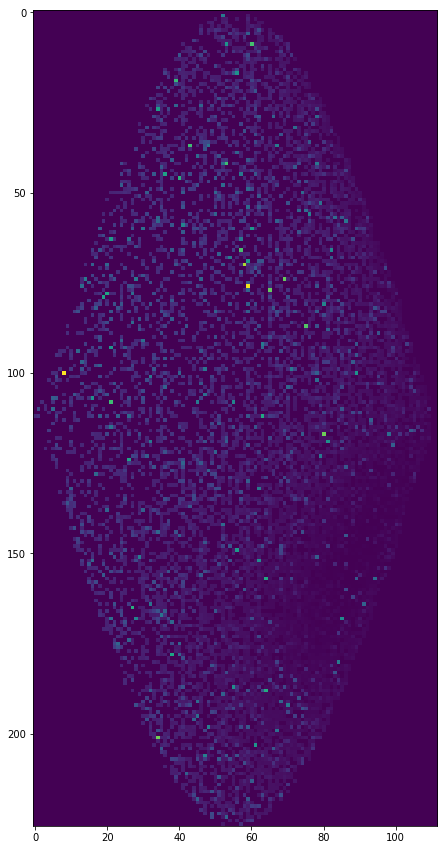

In [130]:
fig = plt.figure(figsize=(15,15))
plt.imshow(data_lpmt[3][:,:,1])

In [48]:
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
import keras.layers as L
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.engine.input_layer import Input

In [54]:
edge_size0 = 226
edge_size1 = 112
inputs = Input(shape=(edge_size0,edge_size1,2))
base_model = residual_network_tail(inputs)

In [60]:
x = L.MaxPool2D()(base_model)
x = L.Flatten()(x)
# let's add a fully-connected layer
#x = L.Dropout(0.)(x)
x = Dense(1024, activation='elu')(x)
#x = L.Dropout(0.5)(x)
x = Dense(512, activation='elu')(x)
predictions = Dense(1)(x)

In [61]:
model = Model(inputs=inputs, outputs=predictions)

In [62]:
model.layers[70].trainable

True

In [63]:
model.compile(optimizer=Adam(lr=4e-4, decay=5e-5), loss='mean_squared_error')

In [64]:
model.build(input_shape=(None, edge_size0,edge_size1,2))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 226, 112, 2)  0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 113, 56, 64)  6336        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 113, 56, 64)  256         conv2d_44[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_41 (LeakyReLU)      (None, 113, 56, 64)  0           batch_normalization_44[0][0]     
__________________________________________________________________________________________________
max_poolin

In [65]:
logdir = 'ResNet_sinus_E.csv'

In [66]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger(logdir, append=True, separator=';')

In [67]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001)

In [68]:
TRAIN_DIR = '~/data/data_dir/'
tr_true_info = pd.read_csv(TRAIN_DIR + 'true_info.csv')

In [69]:
epochs = [5,5,5,3,3,3,1,1,1,1,1,1,1]

In [70]:
rg

array([    0, 20000, 40000, 60000, 80000])

In [72]:
X_test = data_lpmt

In [73]:
y_test = tr_true_info[(tr_true_info['evtID'] >= rg[-2]) 
                     & (tr_true_info['evtID'] < rg[-1])]
mask = (y_test.R <= MAXR)
X_test = X_test[mask]
y_test = y_test[mask][['E']].values

In [91]:
def scale(X):
    X[:,:,:,1] /= 20 

In [106]:
def scaler(X,y):
    X[:,:,:,1] /= 20 

In [93]:
scale(X_test)

In [ ]:
import gc
for i in range(len(epochs)):
    for start, end in zip(rg[:-2], rg[1:-1]):
        print("ITERATION: ", i)
        data_lpmt_cur = np.load(LTRAIN + '_' + str(start) +'without_noise_sin.npy')
        ys = tr_true_info[(tr_true_info['evtID'] >= start) 
                            & (tr_true_info['evtID'] < end)]
        mask = (ys.R <= MAXR)
        data_lpmt_cur = data_lpmt_cur[mask]
        y_cur = ys[mask][['E']].values
        #Scale
        scale(data_lpmt_cur)
        
        #X_train, X_test, y_train, y_test = train_test_split(data_lpmt, y_val, test_size=0.2, random_state=45)
        out = model.fit(data_lpmt_cur, y_cur, batch_size=32, 
                epochs=epochs[i],
                callbacks=[csv_logger, reduce_lr],
                validation_data=(X_test, y_test),
                shuffle=True)
    gc.collect()

ITERATION:  0
Train on 18361 samples, validate on 18402 samples
Epoch 1/5
18361/18361 [==============================] - 669s 36ms/step - loss: 1.0508 - val_loss: 0.6635
Epoch 2/5
18361/18361 [==============================] - 667s 36ms/step - loss: 0.9219 - val_loss: 0.6253
Epoch 3/5
18361/18361 [==============================] - 668s 36ms/step - loss: 0.4961 - val_loss: 0.8150
Epoch 4/5
18361/18361 [==============================] - 666s 36ms/step - loss: 0.4863 - val_loss: 0.1440
Epoch 5/5
18361/18361 [==============================] - 666s 36ms/step - loss: 0.2558 - val_loss: 0.1661
ITERATION:  0
Train on 18357 samples, validate on 18402 samples
Epoch 1/5
18357/18357 [==============================] - 668s 36ms/step - loss: 0.2500 - val_loss: 0.0854
Epoch 2/5
18357/18357 [==============================] - 666s 36ms/step - loss: 0.2180 - val_loss: 0.0755
Epoch 3/5
18357/18357 [==============================] - 667s 36ms/step - loss: 0.1532 - val_loss: 0.2849
Epoch 4/5
18357/18357 [=

In [107]:
training_generator = DataGenerator(24,rg=rg,
                                   file_names=[LTRAIN + '_' + str(start) +'without_noise_sin.npy' for start in rg[:-2]],
                                  y_true=tr_true_info,
                                  target_names=['E'],
                                  scaler=scaler)

In [108]:
model.fit_generator(generator=training_generator,
                    validation_data=(X_test, y_test),
                    use_multiprocessing=True,
                    workers=6,
                    callbacks=[csv_logger, reduce_lr],
                   epochs=4*10)

Epoch 1/40
765/765 [==============================] - 746s 975ms/step - loss: 0.0123 - val_loss: 0.0230
Epoch 2/40
765/765 [==============================] - 740s 967ms/step - loss: 0.0104 - val_loss: 0.0222
Epoch 3/40
765/765 [==============================] - 741s 968ms/step - loss: 0.0108 - val_loss: 0.0199
Epoch 4/40
765/765 [==============================] - 740s 968ms/step - loss: 0.0098 - val_loss: 0.1173
Epoch 5/40
765/765 [==============================] - 740s 968ms/step - loss: 0.0147 - val_loss: 0.0249
Epoch 6/40
765/765 [==============================] - 741s 968ms/step - loss: 0.0083 - val_loss: 0.0239
Epoch 7/40
765/765 [==============================] - 741s 968ms/step - loss: 0.0095 - val_loss: 0.0220
Epoch 8/40
765/765 [==============================] - 741s 969ms/step - loss: 0.0090 - val_loss: 0.0169
Epoch 9/40
765/765 [==============================] - 741s 969ms/step - loss: 0.0093 - val_loss: 0.0210
Epoch 10/40
765/765 [==============================] - 741s 968m

In [111]:
def test_sigmas(model, test_dir='/mnt/iprovilkov/data_dir/', test_column='E', MAXR=MAXR, 
                time=False, recompute=False):
    sigmas = {}
    MSEs = {}
    predictions = {}
    CONST = 1.022
    for energy in tqdm(range(10)):
        try:
            if recompute:
                raise Exception("Recompute")
            if time:
                data_lpmt = np.load(test_dir + str(energy) + 'data_lpmt_without_noise_sin.npy')
            else:
                data_lpmt = np.load(test_dir + str(energy) + 'data_lpmt_without_noise_sin.npy')
            true_info = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'true_info.csv')
        except: 
            lpmt_hits = pd.read_hdf(test_dir + str(energy)+'MeV_'+ 'lpmt_hits.h5', mode='r') 
            spmt_hits = pd.read_hdf(test_dir + str(energy)+'MeV_'+'spmt_hits.h5', mode='r')
            lpmt_hits = lpmt_hits[lpmt_hits.isDN==False]
            spmt_hits = spmt_hits[spmt_hits.isDN==False]
            pos = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'lpmt_pos.csv') 
            spmt_pos = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'spmt_pos.csv') 
            true_info = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'true_info.csv')
            if time:
                print("Compute...")
                data_lpmt, event_to_id = get_data_2dprojection(lpmt_hits,
                                                None,
                                                pos,
                                                true_info,
                                                edge_size0=226,
                                                edge_size1=112,
                                                use_spmt=False,
                                                time='min',
                                                )
                np.save(test_dir+str(energy)+'data_lpmt_without_noise_sin', data_lpmt)
            else:
                pass
            
        mask = (true_info.R<=MAXR)
        data_lpmt = data_lpmt[mask]
        true_info = true_info[mask]
        y_test = true_info[test_column]
        scaler(data_lpmt, y_test)
        preds = np.maximum(model.predict(data_lpmt), 0)
        print(y_test.mean())
        predictions[energy] = preds
        MSEs[energy] = mean_squared_error(preds, y_test)
        # in percents
        sigmas[energy] = np.std(preds.reshape(-1) - y_test.values.reshape(-1)) / (energy + CONST)
    print("+")
    return sigmas, MSEs, predictions

In [115]:
from tqdm import tqdm
from sklearn.metrics.pairwise import paired_euclidean_distances
from sklearn.metrics import mean_squared_error

(0, 0.3)

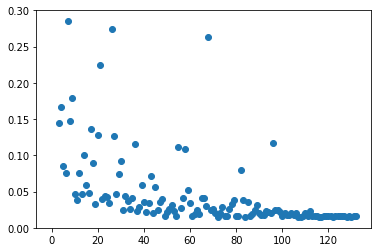

In [117]:
cs = pd.read_csv(logdir, sep=';')
plt.scatter(np.arange(0, cs.shape[0]), cs['val_loss'].values)
plt.ylim(0,0.3)

In [120]:
cs['loss'].values[-10:]

array([0.0020752 , 0.0021274 , 0.00201333, 0.00205793, 0.00218815,
       0.00206221, 0.00207689, 0.00210772, 0.00202216, 0.00204633])

In [116]:
sigmas, MSEs, predictions = test_sigmas(model, time=True, recompute=False)


 10%|█         | 1/10 [00:14<02:13, 14.79s/it]

0.5109988999999999



 20%|██        | 2/10 [00:30<01:59, 14.96s/it]

1.5109988697622994



 30%|███       | 3/10 [00:45<01:45, 15.05s/it]

2.5109990065502177



 40%|████      | 4/10 [01:00<01:30, 15.00s/it]

3.5109988987951803



 50%|█████     | 5/10 [01:15<01:15, 15.15s/it]

4.510998806956522



 60%|██████    | 6/10 [01:31<01:01, 15.30s/it]

5.510998686870312



 70%|███████   | 7/10 [01:46<00:45, 15.18s/it]

6.510998666593649



 80%|████████  | 8/10 [02:01<00:30, 15.08s/it]

7.510998798899285



 90%|█████████ | 9/10 [02:16<00:15, 15.02s/it]

8.510999212171052



100%|██████████| 10/10 [02:31<00:00, 15.03s/it]

9.510998837121212
+


In [118]:
sigmas, MSEs

({0: 0.036301578356133374,
  1: 0.029217005690512762,
  2: 0.023470900848904807,
  3: 0.024737039369049155,
  4: 0.018739623440782133,
  5: 0.018146681950313208,
  6: 0.021182187173356796,
  7: 0.016301623506855045,
  8: 0.015459551628696826,
  9: 0.016528574950344543},
 {0: 0.00447003954165256,
  1: 0.003636291469315232,
  2: 0.005038682194198984,
  3: 0.009947643309935915,
  4: 0.009082961907623402,
  5: 0.012202136059534038,
  6: 0.023815511627247817,
  7: 0.01883730285736746,
  8: 0.02145273887658233,
  9: 0.031054516007096893})